In [42]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [43]:
dataset = CIFAR10(root='../data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='../data/', train=False, transform=ToTensor())

Files already downloaded and verified


In [44]:
dataset_size = len(dataset)
dataset_size

50000

In [45]:
test_dataset_size = len(test_dataset)
test_dataset_size

10000

In [46]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [47]:
num_classes = len(dataset.classes)
num_classes

10

In [48]:
img, label = dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

label (numeric): 6
label (textual): frog


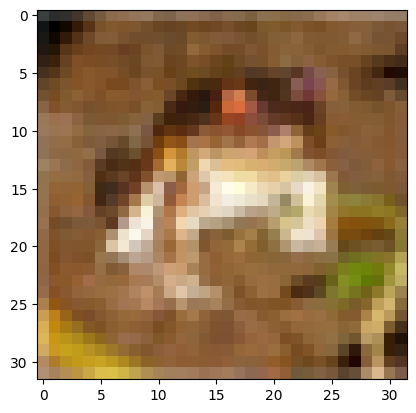

In [49]:
img, label = dataset[0]
plt.imshow(img.permute(1,2,0))
print('label (numeric):', label)
print('label (textual):', classes[label])

In [50]:
num_items = [0] * len(dataset.classes)
for el in dataset:
    img, label = el
    num_items[label] += 1

num_items

[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]

In [51]:
torch.manual_seed(43)
val_size = 5000
train_size = len(dataset) - val_size

In [52]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [70]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)



In [71]:
batch_size=128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

images.shape: torch.Size([128, 3, 32, 32])


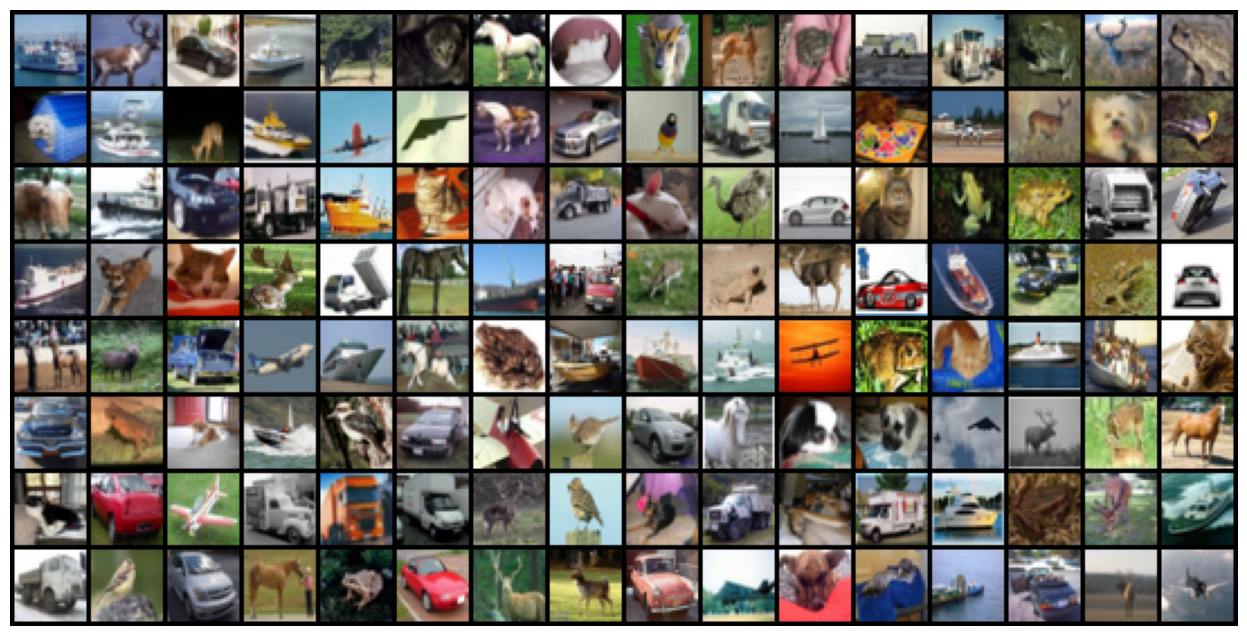

In [33]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images.cpu(), nrow=16).permute((1, 2, 0)))
    break

In [72]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [73]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [74]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [75]:
class CIFAR10Model(ImageClassificationBase):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        xb = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out) #sigmoid
        #Get predictions using output layer
        out = self.linear2(out)
        return out

In [76]:
input_size = 3*32*32
hidden_size = input_size
output_size = 10

model = to_device(CIFAR10Model(input_size, hidden_size, output_size), device)

In [77]:
history = [evaluate(model, val_loader)]
history


TypeError: iter() returned non-iterator of type 'NoneType'

In [69]:
history += fit(5, 2, model, train_loader, val_loader)

Epoch [0], val_loss: 12.8902, val_acc: 0.0976
Epoch [1], val_loss: 2.3240, val_acc: 0.0986
Epoch [2], val_loss: 2.3126, val_acc: 0.0944


KeyboardInterrupt: 